In [1]:
#IMPORTS
import os
import re
import gc
import sys
import nltk
import json
import time
import wandb
import torch
import random
import requests
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
import torch.nn.functional as F
import collections, functools, operator
from sklearn.svm import SVC
from datasets import Dataset
from tensorflow import keras
from wordcloud import WordCloud
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as ds
from kaggle_secrets import UserSecretsClient
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from transformers import BigBirdTokenizer, BigBirdForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, AutoTokenizer,\
AutoModelForSequenceClassification, Trainer, TrainingArguments, EvalPrediction

In [ ]:
#TODO
#dokończyć dzielenie na paragrafy po embeddingach
#zapuścić trening na v3.1 i sprawdzić wyniki na license_division_03_02(excel z predykcjami)
#zapuścić crossval hiperparameter tunning na v3.1 ale z test setem
#zapuścić trening na NOWYM v3.1 i sprawdzić wyniki na license_division_03_02(excel z predykcjami)

#EURO/PLN
#dodać kod który będzie szczytywał ostanie wartościu kursu(minutowe)

In [2]:
#Installing and logging to wandb 
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb_key")
wandb.login(key=wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

<a id="menu"></a>
# Table of Contents
* [DATA LOAD](#DATA-LOAD)
* [DATA PREPROCESSING](#DATA-PREPROCESSING)
* [DATA ANALYSIS - EDA](#DATA-ANALYSIS)
* [<span style="color:fuchsia">PYTORCH</span> EMBEDDINGS](#PYTORCH-EMBEDDINGS)
* [<span style="color:red">GLOVO</span> EMBEDDINGS](#GLOVO-EMBEDDINGS)
* [PCA ANALYSIS](#PCA-ANALYSIS)
* [TRANSFORMER MODELS](#TRANSFORMER-MODELS)
* [CROSS-VALIDATION](#CROSS-VALIDATION)

<a id="DATA-LOAD"></a>
# DATA LOADING // [Menu](#menu)

In [ ]:
#TEXT CORPUS CREATION
COMM_DIRECTORY = '/kaggle/input/licenses/comm_noncomm_data/comm'
NONCOMM_DIRECTORY = '/kaggle/input/licenses/comm_noncomm_data/noncomm'

COMM_DIRECTORY_GEN = '/kaggle/input/licenses/comm_noncomm_data/comm_gen'
NONCOMM_DIRECTORY_GEN = '/kaggle/input/licenses/comm_noncomm_data/noncomm_gen'

stop_words = set(stopwords.words('english'))

def tokkenizer(directory):
    all_sentences = []
    text_corpus = ''
    
    for file in os.listdir(directory):
        try:
            with open(os.path.join(directory, file)) as txt_file:
                temp_corpus = txt_file.read()
        except: #some files are encoded in ANSI
            with open(os.path.join(directory, file), encoding="cp1252") as txt_file:
                temp_corpus = txt_file.read()
        
        #TEXT PREPROCESSING
        #filt = r"[\n\-\=\\\/\t_`~¤•#\xa0–—]"
        filt = '[^a-zA-Z]'
        temp_corpus = re.sub(filt, ' ', temp_corpus)
        temp_corpus = re.sub(r" +", ' ', temp_corpus).lower()
        
        text_corpus += temp_corpus #ALL LICENSES TOGETHER
        sentences = sent_tokenize(temp_corpus) #ALL SENTENCES FROM TXT
        all_sentences.append(sentences)
        
    token_text = word_tokenize(text_corpus) #ALL TOKENS FROM TEXT
    token_text_stop = [w for w in token_text if not w.lower() in stop_words]
    return token_text, token_text_stop, all_sentences, text_corpus, 

comm_tokens, comm_tokens_stop, comm_sentences, comm_corpus = tokkenizer(COMM_DIRECTORY_GEN)
noncomm_tokens, noncomm_tokens_stop, noncomm_sentences, noncomm_corpus = tokkenizer(NONCOMM_DIRECTORY_GEN)

In [2]:
#CREATING XLSX DATA SET - PARAGRAPH CLASSIFICATION
DATA_XLSX = '/kaggle/input/licenses/paragraphs_classification_dataset_v3_1 (1).xlsx'
data = pd.read_excel(DATA_XLSX)

train_data = data[data['mlUse']=='training']
valid_data = data[data['mlUse']=='valid']
test_data = data[data['mlUse']=='test']

#PREDICTION XLSX DATA SET - PARAGRAPH CLASSIFICATION
DATA_XLSX = '/kaggle/input/licenses/Hand_made_para.xlsx'
hand_made_para = pd.read_excel(DATA_XLSX)

DATA_XLSX = '/kaggle/input/licenses/Iza_paragraphs.csv'
iza_paragraphs = pd.read_csv(DATA_XLSX)

DATA_XLSX = '/kaggle/input/licenses/NLTK AGA.xlsx'
nltk_aga = pd.read_excel(DATA_XLSX)

<a id="DATA-PREPROCESSING"></a>
# DATA PREPROCESSING // [Menu](#menu)

In [3]:
def preprocess(text):
    stringed = text.strip()
    stringed = stringed.replace("\n"," ")
    stringed = stringed.replace("\t"," ")
    stringed = stringed.replace('"',"'")
    stringed = stringed.replace("'"," ")
    stringed = stringed.replace(","," ")
    stringed = stringed.replace("-"," ")
    stringed = stringed.replace("="," ")
    stringed = stringed.replace("#"," ")
    stringed = stringed.replace("_"," ")
    stringed = stringed.replace("*"," ")
    stringed = stringed.replace(";"," ")
    stringed = stringed.replace("`"," ")
    stringed = stringed.replace("\xa0","")
    stringed = re.sub('.[u][0-9][0-9]..', ' ', stringed)
    stringed = stringed.lower()
    filt = r"[\n\-\=\\\/\t_`~¤•#\xa0–—]"
    stringed = re.sub(filt, ' ', stringed)
    stringed = re.sub(' +', ' ', stringed)
    return stringed

<a id="DATA-ANALYSIS"></a>
# DATA ANALYSIS - EDA // [Menu](#menu)

In [ ]:
#SENTIMENT ANALYSIS
def sentiment_analizer(corpus, text):
    sia = SentimentIntensityAnalyzer()
    corpus_sent = corpus.split('. ')
    corpus_sent_filt = [sent for sent in corpus_sent if len(sent.split()) > 3]
    scores = list(map(lambda x: sia.polarity_scores(x), corpus_sent_filt))
    result = dict(functools.reduce(operator.add, map(collections.Counter, scores)))
    result = {key: value / len(scores) for key, value in result.items()}
    print(text)
    print(result)

sentiment_analizer(comm_corpus, 'COMMERCIONAL')
sentiment_analizer(noncomm_corpus, 'NONCOMMERCIONAL')

In [ ]:
#CREATE WORD CLOUD
def create_word_cloud(text):
    comm_wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white', stopwords={''},
                    min_font_size = 10).generate(' '.join(text))

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(comm_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

create_word_cloud(comm_tokens)
create_word_cloud(noncomm_tokens)

In [ ]:
stop_words_modi = {'the', ',', 'of', '.', '-', 'to', 'this', 'in', 'that', 'a', '(', ')'}

In [ ]:
#MOST COMMON WORDS AND DIFFERENCES BETWEEN THEM
comm_most_common = nltk.FreqDist(w.lower() for w in comm_tokens)
noncomm_most_common = nltk.FreqDist(w.lower() for w in noncomm_tokens)
comm_top = comm_most_common.most_common(100)
noncomm_top = noncomm_most_common.most_common(100)

comm_only_words = list(map(lambda x: re.sub("[0-9(),' \"]",'' ,str(x)), comm_top))
noncomm_only_words = list(map(lambda x: re.sub("[0-9(),' \"]",'' ,str(x)), noncomm_top))

diff = list(set(comm_only_words) - set(noncomm_only_words))
diff_comparision = [[w, comm_most_common[w]/len(comm_most_common), noncomm_most_common[w]/len(noncomm_most_common)] for w in diff]

print(diff)
print()
print(diff_comparision)

<a id="PYTORCH-EMBEDDINGS"></a>
# **<span style="color:blue">PYTORCH</span> EMBEDDINGS** // [Menu](#menu)

In [ ]:
from itertools import repeat

#CREATING EMBEDDING DICTIONARY
sent_idx = {}
for idx, i in enumerate(set(comm_tokens + noncomm_tokens)):
    sent_idx[i] = idx 

#CREATING DATASET FOR PYTORCH MODEL
def sent_to_vec(sent, dictionary):
    words = word_tokenize(sent)
    return list(map(lambda x: dictionary[x], words))

class dataset(ds):
    def __init__(self,x,y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    def __len__(self):
        return self.length
    
data = comm_sentences + noncomm_sentences
data = list(map(sent_to_vec, data, repeat(sent_idx)))
labels = np.concatenate((np.full(len(comm_sentences), 1), np.full(len(noncomm_sentences), 0)))

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

trainset = dataset(x_train, y_train)
trainloader = DataLoader(trainset, batch_size=1, shuffle=False) 

In [ ]:
#CREATING PYTORCH MODEL + EMBEDDINGS
EMBEDDING_DIM = 300

#MODEL CREATION
class license_model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super(license_model, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds_mean = torch.mean(embeds, 0)
        layer1 = F.relu(self.linear1(embeds_mean))
        drop1 = self.dropout(layer1)
        layer2 = F.relu(self.linear2(drop1))
        drop2 = self.dropout(layer2)
        layer3 = self.linear3(drop2)
        prob = F.sigmoid(layer3)
        return prob
     
losses = []
loss_function = nn.BCELoss()
model = license_model(len(sent_idx), EMBEDDING_DIM)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for idx, sentence in enumerate(x_train):

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        x = torch.tensor(sent_to_vec(*sentence, sent_idx))
        #context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(x)
        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([y_train[idx]], dtype=torch.float32))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)

count = 0
with torch.no_grad():
    for idx, sentence in enumerate(x_test):
        x = torch.tensor(sent_to_vec(*sentence, sent_idx))
        # calculate outputs by running images through the network
        outputs = model(x)
        # the class with the highest energy is what we choose as prediction
        if torch.round(outputs) == y_test[idx]:
            count += 1
    print(count)  
    print(count/(idx+1))
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
#print(model.embeddings.weight[word_to_ix["beauty"]])

<a id="GLOVO-EMBEDDINGS"></a>
# **<span style="color:red">GLOVO</span> EMBEDDINGS** // [Menu](#menu)

In [ ]:
#EMBEDDING MODELS

#DOWNLOAD EMBEDDINGS
!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove*.zip
!rm glove*.zip

In [ ]:
# CREATE EMBEDDINGS DICTIONARY FROM TEXT
EMBEDD_FILEPATH = '/kaggle/working/glove.840B.300d.txt'
EMBEDDING_DIM = 300

#CREATING OUR OWN EMBEDDING DICTIONARY FROM GLOVO
def embedding_for_vocab(filepath, sentences, embedding_dim):
    
    sentences = list(itertools.chain(*sentences)) #UNPACKING LIST FOR TOKKENIZER
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
  
    with open(filepath, encoding="utf8") as file:
        for line in file:
            word, *vector = line.split()
            try:
                float(vector[0])
                if word in word_index:
                    idx = word_index[word]
                    embedding_matrix[idx] = np.array(vector, dtype=np.float32)
            except:
                print(word)
                continue
    return embedding_matrix, tokenizer

comm_embeddings, comm_tokenizer = embedding_for_vocab(EMBEDD_FILEPATH, comm_sentences, EMBEDDING_DIM)
noncomm_embeddings, noncomm_tokenizer = embedding_for_vocab(EMBEDD_FILEPATH, noncomm_sentences, EMBEDDING_DIM)

In [ ]:
#CREATE EMBEDDING VECTOR(300:1) FOR EVERY LICENSE IN OUR DATASET
def sentences_to_embeddings(licenses, embedded_vectors, tokenizer, label, embedding_dim=300):
    
    data = np.zeros(shape=(len(licenses), embedding_dim))
    labels = np.full(len(licenses), label)

    for i, license in enumerate(licenses):
        license_embeddings = np.zeros(shape=(len(license), embedding_dim))
        
        for j, sent in enumerate(license):
            sent_lenght = len(sent.split())
            sent_embeddings = np.zeros(shape=(sent_lenght, embedding_dim))
            
            for k, word in enumerate(sent.split()):
                try:
                    word = re.sub('[^a-z]', '', word)
                    idx = tokenizer.word_index[word]
                    sent_embeddings[k] = embedded_vectors[j]
                except: #IF WORD WILL NOT BE FOUND IN GLOVO
                    continue    
            license_embeddings[j] = np.mean(sent_embeddings, axis=0) 
        data[i] = np.mean(license_embeddings, axis=0)
    return data, labels 

comm_embedings, comm_labels = sentences_to_embeddings(comm_sentences, comm_embeddings, comm_tokenizer, 1)
noncomm_embedings, noncomm_labels = sentences_to_embeddings(noncomm_sentences, comm_embeddings, noncomm_tokenizer, 0)

In [ ]:
def sentences_to_embedings(licenses, embedded_vectors, tokenizer, label, embedding_dim=300):
    
    licences_sent = list(itertools.chain(*licenses))
    data = np.zeros(shape=(len(licences_sent), embedding_dim))
    labels = np.full((len(licences_sent)), label)

    for i, sentence in enumerate(licences_sent):
        sent_lenght = len(sentence.split())
        embeddings = np.zeros(shape=(sent_lenght, embedding_dim))
        exceptions = 0
        for j, word in enumerate(sentence.split()):
            try:
                word = re.sub('[^a-z]', '', word)
                idx = tokenizer.word_index[word]
                embeddings[j] = embedded_vectors[idx]
            except:
                exceptions += 1
                continue
            if sent_lenght - exceptions == 0:
                continue
            #data[i] = np.mean(embeddings, axis=0)
            data[i] = np.sum(embeddings, axis=0)/sent_lenght - exceptions
    return data, labels 

comm_embedings, comm_labels = sentences_to_embedings(comm_sentences, comm_embeddings, comm_tokenizer, 1)
noncomm_embedings, noncomm_labels = sentences_to_embedings(noncomm_sentences, comm_embeddings, noncomm_tokenizer, 0)

In [ ]:
dupa = [1,2,3,4]
for i in dupa:
    try:
        print(i+1)
        continue
    except:
        print('dupa')
    print('dupa22')

In [ ]:
embed_sent = []
all_sent = []
para = []
def paragraphs_cut(directory, tokkenizer, embeddings):
    
    for file in os.listdir(directory):
        try:
            with open(os.path.join(directory, file)) as txt_file:
                temp_corpus = txt_file.read()
        except: #some files are encoded in ANSI
            with open(os.path.join(directory, file), encoding="cp1252") as txt_file:
                temp_corpus = txt_file.read()
        
        #TEXT PREPROCESSING
        filt = '[^a-zA-Z]'
        temp_corpus = re.sub(filt, ' ', temp_corpus)
        temp_corpus = re.sub(r" +", ' ', temp_corpus).lower()
        
        sentences = sent_tokenize(temp_corpus) #ALL SENTENCES FROM TXT
        for sentence in sentences:
            all_sent.append(sentence)
            sentence_embedd = 0
            
            for word in sentence.split():
                word_idx = tokkenizer.word_index[word]
                sentence_embedd += embeddings[word_idx]
            embed_sent.append(sentence_embedd/len(sentence.split()))
        
        for idx, sent in enumerate(embed_sent):
            print(idx)
            try: #IF FIRST IN THE SENTENCE
                first_sec = np.sum(embed_sent - embed_sent[idx-1])
            except:
                para.append(all_sent[idx])
                continue
            try: #IF LAST IN THE SENTENCE
                sec_third = np.sum(embed_sent - embed_sent[idx+1])
            except:
                para[-1] += all_sent[idx]
                continue
            if first_sec < sec_third:
                para[len(para)-1] += all_sent[idx]
            else:
                para.append(all_sent[idx])
    return para
para = paragraphs_cut(COMM_DIRECTORY_GEN, comm_tokenizer, comm_embeddings)          

<a id="PCA-ANALYSIS"></a>
# **PCA ANALYSIS** // [Menu](#menu)

In [ ]:
def pca_on_data(data, dimension=2):
    pca = PCA(n_components=dimension)
    pca.fit(data)
    return pca.transform(data)

comm_embedings_pca = pca_on_data(comm_embedings)
noncomm_embedings_pca = pca_on_data(noncomm_embedings)

In [ ]:
#MERGE DATA
x = np.concatenate((comm_embedings_pca, noncomm_embedings_pca))
y = np.concatenate((comm_labels, noncomm_labels))
fig, ax = plt.subplots()
ax.scatter(x[:,0], x[:,1], c=y)

In [ ]:
x_com = comm_embedings_pca
y_com = comm_labels
fig, ax = plt.subplots()
ax.scatter(x_com[:,0], x_com[:,1], c=y_com)

In [ ]:
x_equel = np.concatenate((comm_embedings_pca[:657], noncomm_embedings_pca))
y_equel = np.concatenate((comm_labels[:657], noncomm_labels))
fig, ax = plt.subplots()
ax.scatter(x_equel[:,0], x_equel[:,1], c=y_equel)

In [ ]:
#SVM
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f'Accuracy:{accuracy_score(y_test, y_pred)}')

In [ ]:
#SVM WITH KFOLD
kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
    model = SVC()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Accuracy:{accuracy_score(y_test, y_pred)}')

In [ ]:
def check_best_pca(data, labels):
    best_score = 0
    best_pca = 0
    for i in range(1, 60):
        comm_embedings_pca = pca_on_data(data[0], i)
        noncomm_embedings_pca = pca_on_data(data[1], i)
        
        x = np.concatenate((comm_embedings_pca, noncomm_embedings_pca))
        y = np.concatenate((labels[0], labels[1]))
        
        kf = KFold(n_splits=5, shuffle=True)
        score = 0
        for train_index, test_index in kf.split(x):
            x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
            model = SVC()
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            score += accuracy_score(y_test, y_pred) 
            
        if score/5 > best_score:
            best_score = score/5
            best_pca = i
    print(f'BEST SCORE:{best_score}\nBEST PCA:{best_pca}')        
        
check_best_pca([comm_embedings, noncomm_embedings], [comm_labels, noncomm_labels])

In [ ]:
#LOAD DATA FROM XLSX
data_test = pd.read_excel('/kaggle/input/licenses/powiekszenie_testu(Gen Noncomm).xlsx')
x_xls = data_test['textContent']
y_xls = data_test['classificationAnnotation']

In [ ]:
#TOKENIZE XLSX DATA
def from_xmls(text):
    text_corpus =''
    sentences = []
    for i in text:
        filt = r"[\n\-\=\\\/\t_`~¤•#\xa0–—]"
        temp_corpus = re.sub(filt, ' ', i)
        temp_corpus = re.sub(r" +", ' ', temp_corpus).lower()
        sentences.append(sent_tokenize(temp_corpus))

    return sentences

comm_sent_pred = from_xmls(x_xls[0:10])
noncomm_sent_pred = from_xmls(x_xls[10:])

In [ ]:
#TEST OUR MODEL ON XLSX DATA
EMBEDDING_DIM = 300

comm_embeddings_pred, comm_tokenizer_pred = embedding_for_vocab(EMBEDD_FILEPATH, comm_sent_pred, EMBEDDING_DIM)
noncomm_embeddings_pred, noncomm_tokenizer_pred = embedding_for_vocab(EMBEDD_FILEPATH, noncomm_sent_pred, EMBEDDING_DIM)

comm_embedings_pred, comm_labels_pred = sentences_to_embedings(comm_sent_pred, comm_embeddings_pred, comm_tokenizer_pred, 1)
noncomm_embedings_pred, noncomm_labels_pred = sentences_to_embedings(noncomm_sent_pred, noncomm_embeddings_pred, noncomm_tokenizer_pred, 0)

comm_embedings_pca_pred = pca_on_data(comm_embedings_pred)
noncomm_embedings_pca_pred = pca_on_data(noncomm_embedings_pred)

x_testing = np.concatenate((comm_embedings_pca_pred, noncomm_embedings_pca_pred))
y_testing = np.concatenate((comm_labels_pred, noncomm_labels_pred))

test_x, test_y = shuffle(x_testing, y_testing, random_state=0)

y_pred = model.predict(test_x)
print(f'Accuracy:{accuracy_score(test_y, y_pred)}')

In [ ]:
y_true = [1,1,1,1,1,1,1,1,1,1]
examples = list(map(len, comm_sent_pred))
predictions = []
temp = 0  
for i in examples:
    print(f'{temp} - {temp+i}')
    y_pred = model.predict(test_x[temp:temp+i])
    temp += i
    pred = round(np.mean(y_pred))
    predictions.append(pred)
''' 
print()
examples = list(map(len, noncomm_sent_pred))
for i in examples:
    print(f'{temp} - {temp+i}')
    y_pred = model.predict(test_x[temp:temp+i])
    temp += i
    pred = round(np.mean(y_pred))
    predictions.append(pred) 
'''

print(f'Accuracy:{accuracy_score(y_true, predictions)}') 

<a id="TRANSFORMER-MODELS"></a>
# **TRANSFORMER MODELS** // [Menu](#menu)

In [ ]:
#TRANSFORMER MODELS

#CREATING DATAFRAME FROM TEXT CORPUS
def create_dataframe(text, label, limit=False, limit_lenght=30):
    data = sent_tokenize(text)
    df = pd.DataFrame()
    if limit:
        senteces_lenght = list(map(lambda x: len(x), comm_sentences))
        top_lenght_indexes = np.argpartition(senteces_lenght, -limit_lenght)[-limit_lenght:]
        array = np.array(comm_sentences)
        top_lenght = comm_array.take(top_lenght_indexes)
        df['text'] = top_lenght
        df['label'] = label
    else:    
        df['text'] = data
        df['label'] = label

    return df

comm_df = create_dataframe(comm_sentences, 1)
noncomm_df = create_dataframe(noncomm_sentences, 0)

data = pd.concat([comm_df, noncomm_df])
data.reset_index(inplace=True)
data = shuffle(data)

#MODEL DATA
sentences = data['text']
labels = data['label']

In [ ]:
#INITIALIZE DISTILBERT MODEL TENSORFLOW
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

#MODEL CREATION
def create_model():
    inpt = Input(shape=(max_len,), dtype='int64')
    masks = Input(shape=(max_len,), dtype='int64')
    
    dbert_layer = dbert_model(inpt, attention_mask=masks)[0][:,0,:]
    dense = Dense(512, activation='relu')(dbert_layer)
    dropout = Dropout(0.5)(dense)
    pred = Dense(2, activation='sigmoid')(dropout) #sigmoid/softmax
    #concat_layer= Concatenate()([dense_bert, inpt2])
    model = tf.keras.Model(inputs=[inpt, masks], outputs=[pred, dropout, dbert_layer])
    
    #print(model.summary())
    return model

model=create_model()

#CREATING INPUT DATA
sia = SentimentIntensityAnalyzer()
input_ids=[]
attention_masks=[]
input_semantic=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent, add_special_tokens=True, max_length=max_len, pad_to_max_length=True, return_attention_mask=True, truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])
    input_semantic.append(list(sia.polarity_scores(sent).values()))

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
input_sent = np.array(input_semantic)
labels=np.array(labels)


#DATA SPLIT
train_input, test_input, train_label, test_label, train_mask, test_mask = train_test_split(input_ids, labels, attention_masks, test_size=0.2)

#log_dir='dbert_model'
#model_save_path='./dbert_model.h5'

#callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]


#MODEL CONFUGIRATION
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

history = model.fit([train_input, train_mask], train_label, batch_size=16, epochs=20, validation_data=([test_input, test_mask], test_label))

In [4]:
#DATA FOR PARAGRAPHS MODEL
train_data_sent = train_data['content'].apply(preprocess)
train_label_sent = train_data['labelContains']
valid_data_sent = valid_data['content'].apply(preprocess)
valid_label_sent = valid_data['labelContains']
test_data_sent = test_data['content'].apply(preprocess)
test_label_sent = test_data['labelContains']

# hand_made_paragraphs
hand_made_para_data = hand_made_para['paragraph'].apply(preprocess)
hand_made_para_label = hand_made_para['contain_info']

#additional test
iza_paragraphs_data = iza_paragraphs['licenseParagraph'].apply(preprocess)
iza_paragraphs_label = iza_paragraphs['containsInfo']

#additional test
nltk_aga_data = nltk_aga['paragraph'].apply(preprocess)
nltk_aga_label = nltk_aga['contain_info']

#CROSSVALL
cross_data_sent = pd.concat((train_data_sent, valid_data_sent))
cross_label_sent = pd.concat((train_label_sent, valid_label_sent))
#CROSSVALL V2
#cross_data_sent = pd.concat((train_data_sent, valid_data_sent, test_data_sent))
#cross_label_sent = pd.concat((train_label_sent, valid_label_sent, test_label_sent))

In [ ]:
#DATA FOR COMMERCIAL CLASSIFICATION MODEL
comm_data = data[data['labelContains'] == 1]

comm_data_sent = comm_data[comm_data['labelCommercial'] == 0]
noncomm_data_sent = comm_data[comm_data['labelCommercial'] == 1][0:len(commm_data_sent)]
comm_dataset = pd.concat((comm_data_sent, noncommm_data_sent))

comm_dataset_label = comm_dataset['labelCommercial']
comm_dataset = comm_dataset['content']

In [13]:
#LOADING PYTORCH BERT MODEL
bert_model = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2) #MAX 512 tokens

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
#LOADING PYTORCH DISTILBERT MODEL
distilbert_model = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased") 
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 2) #MAX 128 tokens

In [5]:
#LOADING BIGBIRD MODEL
bigbird_model = 'google/bigbird-roberta-base'
tokenizer = AutoTokenizer.from_pretrained('google/bigbird-roberta-base')
model = BigBirdForSequenceClassification.from_pretrained('google/bigbird-roberta-base', num_labels = 2, return_dict=True) #MAX 4096 tokens

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/826k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassifica

In [ ]:
#CHOOSING CORRECT TOKENS LENGHT - OPTIONAL !!!
tokens_lenght = list(map(lambda x: len(tokenizer.tokenize(x)), sentences))
percentil_50 = int(np.percentile(tokens_lenght, 50))
percentil_75 = int(np.percentile(tokens_lenght, 75))
max_len = percentil_75

In [14]:
#CREATE DATASET
def create_dataset(train_data, train_label):
    
    df_train = pd.DataFrame({'text': train_data, 'labels': train_label})
    df_train.reset_index(drop=True, inplace=True)
    dataset = Dataset.from_pandas(df_train)
    
    return dataset

#PARAGRAPH DATA
train_dataset = create_dataset(cross_data_sent, cross_label_sent)
test_dataset = create_dataset(test_data_sent, test_label_sent)
nltk_aga_dataset = create_dataset(nltk_aga_data, nltk_aga_label)
hand_made_para_dataset = create_dataset(hand_made_para_data, hand_made_para_label)
iza_paragraphs_dataset = create_dataset(iza_paragraphs_data, iza_paragraphs_label)

In [15]:
# define a function that will tokenize the model, and will return the relevant inputs for the model
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = 'max_length', truncation=True, max_length = 512)

train_data = train_dataset.map(tokenization, batched=True, batch_size=1)
test_data = test_dataset.map(tokenization, batched=True, batch_size=1)
train_data = train_data.remove_columns('text')

# define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'specificity': tn/(tn+fp)
    }

  0%|          | 0/152 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

In [16]:
# Define the evaluation function
def evaluate(eval_dataset, model, name, data):
    
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    preds = []
    labels = []
    
    for example in eval_dataset:
        label = example['labels']
        example = tokenizer(example['text'], padding = 'max_length', truncation=True, max_length = 512, return_tensors='pt')
        input_ids = example['input_ids'].to(device)
        attention_mask = example['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions_batch = torch.argmax(logits, axis=1)
            preds.append(int(predictions_batch))
            labels.append(label)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    acc = accuracy_score(labels, preds)
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Specificity: {tn/(tn+fp)}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    #save results
    if data==False:
        return 0
    new_data = data.copy()
    new_data['predictions'] = preds
    new_data['metrics'] = 0
    new_data['metrics'][0:5] = [f'Accuracy:{acc}', f'Precision:{precision}', f'Specificity:{tn/(tn+fp)}', f'Recall{recall}', f'F1:{f1}']
    new_data.to_excel(name)

In [9]:
#parameters to check
l_rate = [0.0009188, 0.0003159, 0.000992, 0.0003674, 0.0005163]
warmup = [360, 77, 291, 115, 106]
decay = [0.09183, 0.03054, 0.0001749, 0.01772, 0.08967]
batch = [4, 1, 8, 1, 1]
epochs = [20, 20, 20, 20, 20]

In [ ]:
#parameters to check
l_rate = [0.0003674, 0.0005163]
warmup = [115, 106]
decay = [0.01772, 0.08967]
batch = [1, 1]
epochs = [20, 20]

In [17]:
# MAIN TRAINING
for idx, lr in enumerate(l_rate):
    
    #INITIALIZE FRESH MODEL
    model = AutoModelForSequenceClassification.from_pretrained(bert_model, num_labels=2)
    
    training_args = TrainingArguments(
        output_dir = '/kaggle/working/',
        num_train_epochs = epochs[idx],
        per_device_train_batch_size = batch[idx],
        gradient_accumulation_steps = 8,
        per_device_eval_batch_size= 1,
        logging_strategy='steps',
        logging_steps = 1,
        load_best_model_at_end=True,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        save_total_limit = 1,
        disable_tqdm = False,
        warmup_steps=warmup[idx],
        weight_decay=decay[idx],
        learning_rate = lr,
        log_level='critical',
        fp16 = False,
        report_to='none'
    )
    # instantiate the trainer class and check for available devices
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        compute_metrics=compute_metrics,
        eval_dataset=test_data
    )
    #TRAIN
    trainer.train()
    #EVALUATE
    #name_nltk = f'Model:{idx} - NLTK_AGA - lr:{lr} - warmup:{warmup[idx]} - decay:{decay[idx]} - epochs:{epochs[idx]} - batch:{batch[idx]}.xlsx'
    #name_hand = f'Model:{idx} - HAND_MADE - lr:{lr} - warmup:{warmup[idx]} - decay:{decay[idx]} - epochs:{epochs[idx]} - batch:{batch[idx]}.xlsx'
    name_iza = f'Model:{idx} - IZA - lr:{lr} - warmup:{warmup[idx]} - decay:{decay[idx]} - epochs:{epochs[idx]} - batch:{batch[idx]}.xlsx'
    
    evaluate(test_data, model, name_iza, False)
    #evaluate(nltk_aga_dataset, model, name_nltk, nltk_aga)
    #evaluate(hand_made_para_dataset, model, name_hand, hand_made_para)
    #evaluate(iza_paragraphs_dataset, model, name_iza, iza_paragraphs)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Specificity
0,0.698900,0.696044,0.450000,0.592593,0.470588,0.800000,0.100000
1,0.702200,0.694155,0.500000,0.166667,0.500000,0.100000,0.900000
2,0.589500,0.676141,0.550000,0.666667,0.529412,0.900000,0.200000
3,0.543400,0.598137,0.700000,0.666667,0.750000,0.600000,0.800000
4,0.472400,0.541905,0.750000,0.736842,0.777778,0.700000,0.800000
5,0.208800,0.796776,0.600000,0.692308,0.562500,0.900000,0.300000
6,0.260000,0.605581,0.700000,0.625000,0.833333,0.500000,0.900000
7,0.066400,0.522991,0.800000,0.777778,0.875000,0.700000,0.900000
8,0.213700,0.396659,0.900000,0.900000,0.900000,0.900000,0.900000
9,0.138800,0.642815,0.800000,0.777778,0.875000,0.700000,0.900000


Accuracy: 0.9
Precision: 1.0
Specificity: 1.0
Recall: 0.8
F1 Score: 0.888888888888889


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Specificity
1,0.666800,0.616620,0.850000,0.869565,0.769231,1.000000,0.700000
2,0.020300,0.501513,0.850000,0.857143,0.818182,0.900000,0.800000
3,1.652200,2.399985,0.650000,0.461538,1.000000,0.300000,1.000000
4,0.297800,0.492516,0.800000,0.750000,1.000000,0.600000,1.000000
5,0.628600,0.731875,0.500000,0.000000,0.000000,0.000000,1.000000
6,0.694700,1.123474,0.500000,0.000000,0.000000,0.000000,1.000000
7,0.820100,0.751445,0.500000,0.666667,0.500000,1.000000,0.000000
8,0.747600,0.693674,0.500000,0.000000,0.000000,0.000000,1.000000
9,0.759100,0.695270,0.500000,0.666667,0.500000,1.000000,0.000000
10,0.680700,0.775985,0.500000,0.000000,0.000000,0.000000,1.000000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

Accuracy: 0.8
Precision: 1.0
Specificity: 1.0
Recall: 0.6
F1 Score: 0.7499999999999999


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Specificity
0,0.710000,0.716065,0.500000,0.642857,0.500000,0.900000,0.100000
1,0.702600,0.696619,0.450000,0.521739,0.461538,0.600000,0.300000
2,0.675000,0.686106,0.600000,0.500000,0.666667,0.400000,0.800000
3,0.642700,0.646440,0.750000,0.761905,0.727273,0.800000,0.700000
4,0.602500,0.617061,0.850000,0.869565,0.769231,1.000000,0.700000
5,0.561700,0.614244,0.700000,0.625000,0.833333,0.500000,0.900000
6,0.459300,0.505140,0.850000,0.869565,0.769231,1.000000,0.700000
7,0.320000,0.522321,0.700000,0.625000,0.833333,0.500000,0.900000
8,0.266000,0.350067,0.900000,0.909091,0.833333,1.000000,0.800000
9,0.250600,0.275099,0.950000,0.947368,1.000000,0.900000,1.000000


Accuracy: 0.9
Precision: 0.8333333333333334
Specificity: 0.8
Recall: 1.0
F1 Score: 0.9090909090909091


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Specificity
1,0.689700,0.647744,0.550000,0.307692,0.666667,0.200000,0.900000
2,0.443200,0.283920,0.850000,0.842105,0.888889,0.800000,0.900000
3,0.391300,0.457842,0.800000,0.750000,1.000000,0.600000,1.000000
4,1.669200,1.994918,0.550000,0.181818,1.000000,0.100000,1.000000
5,0.977000,0.695220,0.500000,0.000000,0.000000,0.000000,1.000000
6,0.780600,0.707046,0.500000,0.666667,0.500000,1.000000,0.000000
7,0.792800,0.780560,0.500000,0.666667,0.500000,1.000000,0.000000
8,0.596700,0.693421,0.500000,0.000000,0.000000,0.000000,1.000000
9,0.787700,0.729422,0.500000,0.666667,0.500000,1.000000,0.000000
10,0.754500,0.872117,0.500000,0.000000,0.000000,0.000000,1.000000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

Accuracy: 0.85
Precision: 0.8888888888888888
Specificity: 0.9
Recall: 0.8
F1 Score: 0.8421052631578948


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Specificity
1,0.613700,0.609099,0.750000,0.800000,0.666667,1.000000,0.500000
2,0.608200,0.643482,0.650000,0.740741,0.588235,1.000000,0.300000
3,1.125900,1.832094,0.500000,0.000000,0.000000,0.000000,1.000000
4,0.130200,0.273814,0.900000,0.909091,0.833333,1.000000,0.800000
5,0.417400,0.434435,0.850000,0.842105,0.888889,0.800000,0.900000
6,0.648300,0.432674,0.850000,0.842105,0.888889,0.800000,0.900000
7,0.845000,0.771178,0.500000,0.666667,0.500000,1.000000,0.000000
8,0.603400,0.693758,0.500000,0.666667,0.500000,1.000000,0.000000
9,0.799500,0.754266,0.500000,0.666667,0.500000,1.000000,0.000000
10,0.828100,1.006519,0.500000,0.000000,0.000000,0.000000,1.000000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

Accuracy: 0.9
Precision: 0.8333333333333334
Specificity: 0.8
Recall: 1.0
F1 Score: 0.9090909090909091


<a id="CROSS-VALIDATION"></a>
# CROSS-VALIDATION SEARCH // [Menu](#menu)

In [ ]:
# CROSSVALL TRAINING WITH HYPERPARAMETER TUNNING
%env WANDB_PROJECT = paragraph_hyperparameter_corrected_epochs
model_count = itertools.count() #couter for model name

#initialize static hyperparameters list
lr=[]
batch=[]
decay=[]
warmup=[]
epochs=[]

#hyperparameters ranges:
lr_range = [1e-9, 1e-3]
batch_range = [1, 4, 8, 16]
decay_range = [0.0001, 0.1]
warmup_range = [0, 500]
epoch_range = [3, 10]

def optuna_hp_space(trial):
    lr.append(trial.suggest_float("learning_rate", lr_range[0], lr_range[1]))
    decay.append(trial.suggest_float("weight_decay", decay_range[0], decay_range[1]))
    warmup.append(trial.suggest_int("warmup_steps", warmup_range[0], warmup_range[1]))
    epochs.append(trial.suggest_int("num_train_epochs", epoch_range[0], epoch_range[1]))
    batch.append(trial.suggest_categorical("per_device_train_batch_size", batch_range))
    
    return {
        "learning_rate": trial.suggest_float("learning_rate", lr_range[0], lr_range[1]),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", batch_range),
        "weight_decay": trial.suggest_float("weight_decay", decay_range[0] , decay_range[1]),
        "warmup_steps": trial.suggest_int("warmup_steps", warmup_range[0] , warmup_range[1]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", epoch_range[0] , epoch_range[1]),
    }

def model_name(trial):
    lr = "{:.4e}".format(trial.suggest_float("learning_rate", lr_range[0], lr_range[1]))
    batch = trial.suggest_categorical("per_device_train_batch_size", batch_range)
    decay = round(trial.suggest_float("weight_decay", decay_range[0], decay_range[1]), 5)
    warmup = trial.suggest_int("warmup_steps", warmup_range[0], warmup_range[1])
    
    return f'MODEL:{model_count.__next__()} - lr:{lr} - batch:{batch} - decay:{decay} - warmup:{warmup}'

def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(bert_model, num_labels=2)

def custom_objective(metrics):
    return metrics["eval_loss"]

kf = KFold()
kf.get_n_splits(cross_data_sent, cross_label_sent)
for train, test in kf.split(cross_data_sent):
    hyper_count = itertools.count()
    name_count = itertools.count()
    
    train_dataset = create_dataset(cross_data_sent.iloc[train], cross_label_sent.iloc[train])
    test_dataset = create_dataset(cross_data_sent.iloc[test], cross_label_sent.iloc[test])
    
    train_data = train_dataset.map(tokenization, batched=True, batch_size=1)
    test_data = test_dataset.map(tokenization, batched=True, batch_size=1)
    
    train_data = train_data.remove_columns('text')
    test_data = test_data.remove_columns('text')
    
    # define the training arguments
    training_args = TrainingArguments(
        output_dir = '/kaggle/working/',
        num_train_epochs = 10,
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8,   
        per_device_eval_batch_size= 1,
        evaluation_strategy = "epoch",
        logging_strategy='steps',
        logging_steps = 1,
        save_strategy = "no",
        save_steps = 100,
        save_total_limit = 1,
        fp16 = False,
        log_level='critical',
        disable_tqdm = False,
        report_to='wandb'
    )
    
    # instantiate the trainer class and check for available devices
    trainer = Trainer(
        model=None,
        args=training_args,
        train_dataset=train_data,
        compute_metrics=compute_metrics,
        eval_dataset=test_data,
        model_init=model_init,
    )
    
    # configuration for optuna hyperparameter search
    best_trial = trainer.hyperparameter_search(
        direction="minimize",
        backend="optuna",
        hp_space=optuna_hp_space,
        n_trials=60,
        hp_name=model_name,
        compute_objective=custom_objective
    )
    
    #use same hyperparameters as in the first run
    def optuna_hp_space(trial):
        idx = hyper_count.__next__()
        return {
            "learning_rate": lr[idx],
            "per_device_train_batch_size": batch[idx],
            "weight_decay": decay[idx],
            "warmup_steps": warmup[idx],
            'num_train_epochs': epochs[idx]
        }
    
    def model_name(trial):
        idx = name_count.__next__()
        return f'MODEL:{model_count.__next__()} - lr:{"{:.4e}".format(lr[idx])} - batch:{batch[idx]} - decay:{round(decay[idx],5)} - warmup:{warmup[idx]}'

In [ ]:
print(results_cross)
print()
print(results_cross.mean())
print()
print(results_test)
print()
print(results_test.mean())

In [ ]:
#CLEAR GPU MEMORY
model.cpu()
del training_args
del trainer
del model

gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

# BERT
**COMMERCIAL TRAINING (38 TRAINING - 8 TEST)**

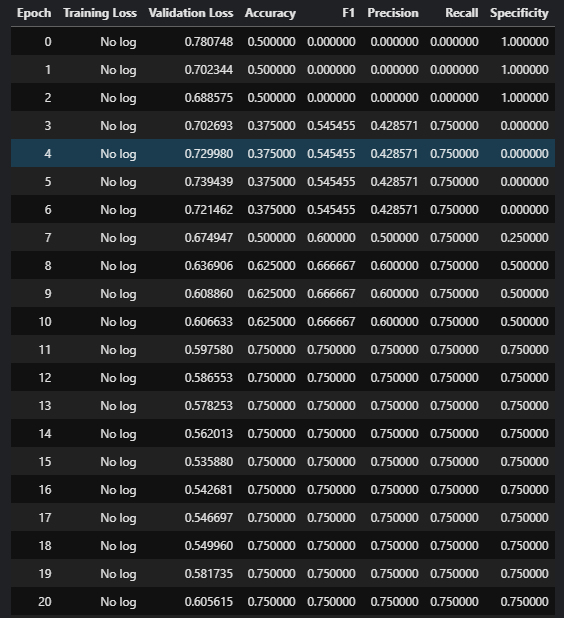

**PARAGRAPHS TRAINING**

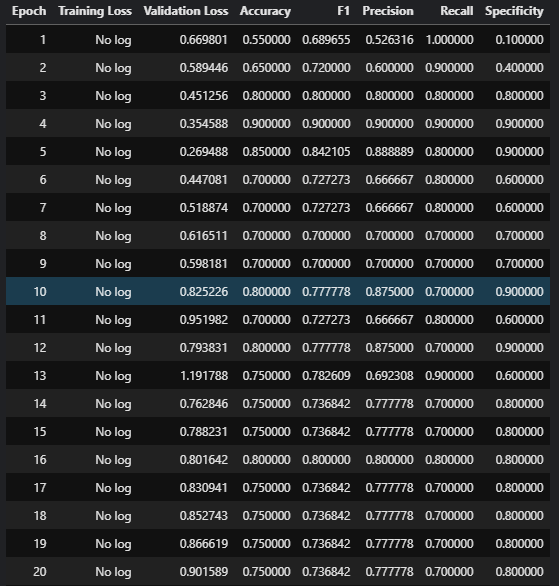

# DISTILBERT

**COMMERCIAL TRAINING (38 TRAINING - 8 TEST)**

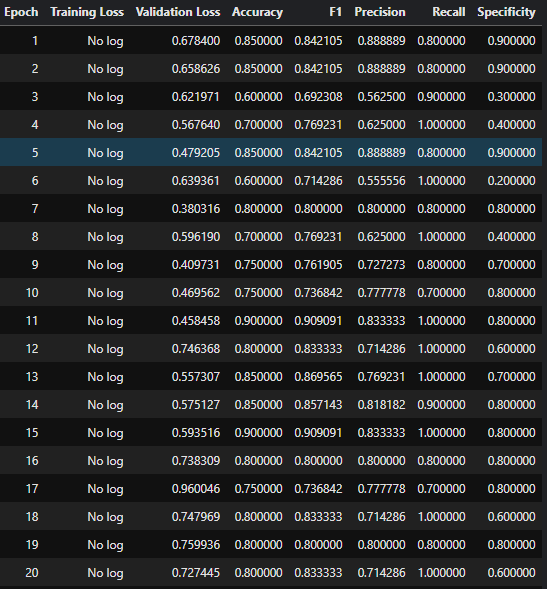

**PARAGRAPHS TRAINING**

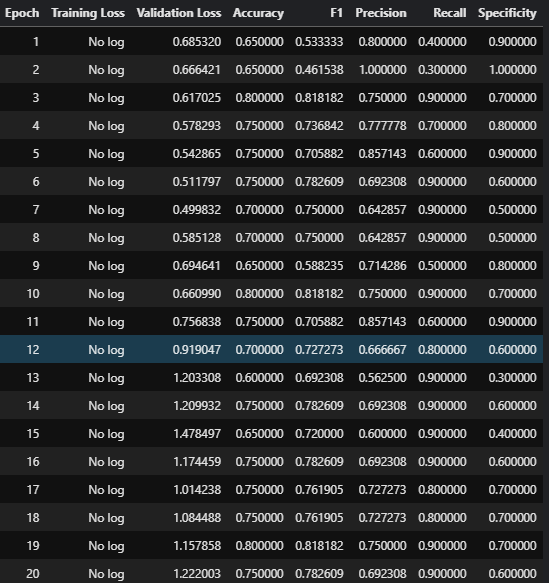